# Connecting to the Prompt Hub

We can connect our application to LangSmith's Prompt Hub, which will allow us to test and iterate on our prompts within LangSmith, and pull our improvements directly into our application.

### Setup

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = ""
os.environ["LANGSMITH_API_KEY"] = ""
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langsmith-academy"  #not used

In [11]:
# Or you can use a .env file
from dotenv import load_dotenv
load_dotenv(dotenv_path="C:/Users/Lenovo/Documents/code/mat496/.env", override=True) #my path 

True

### Pull a prompt from Prompt Hub

Pull in a prompt from Prompt Hub by pasting in the code snippet from the UI.

#in the langsmith dashboard we create a prompt first thats a chat style prompt that is a list of messages
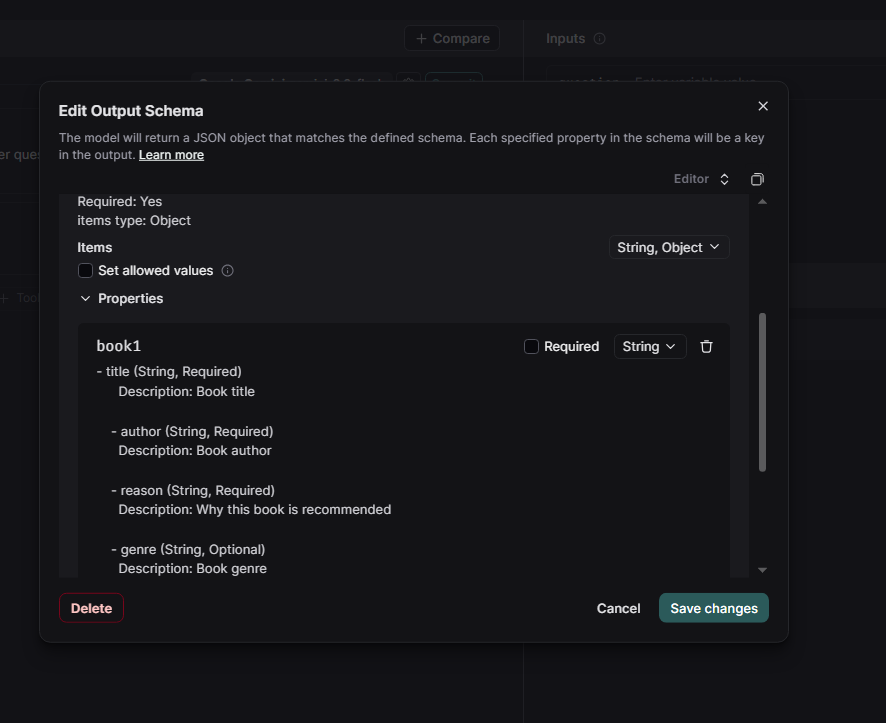
#we have saved a output schema similar to one used in the previous file. it is an array of objects for book recomendations. this time we save it to the prompt hub.

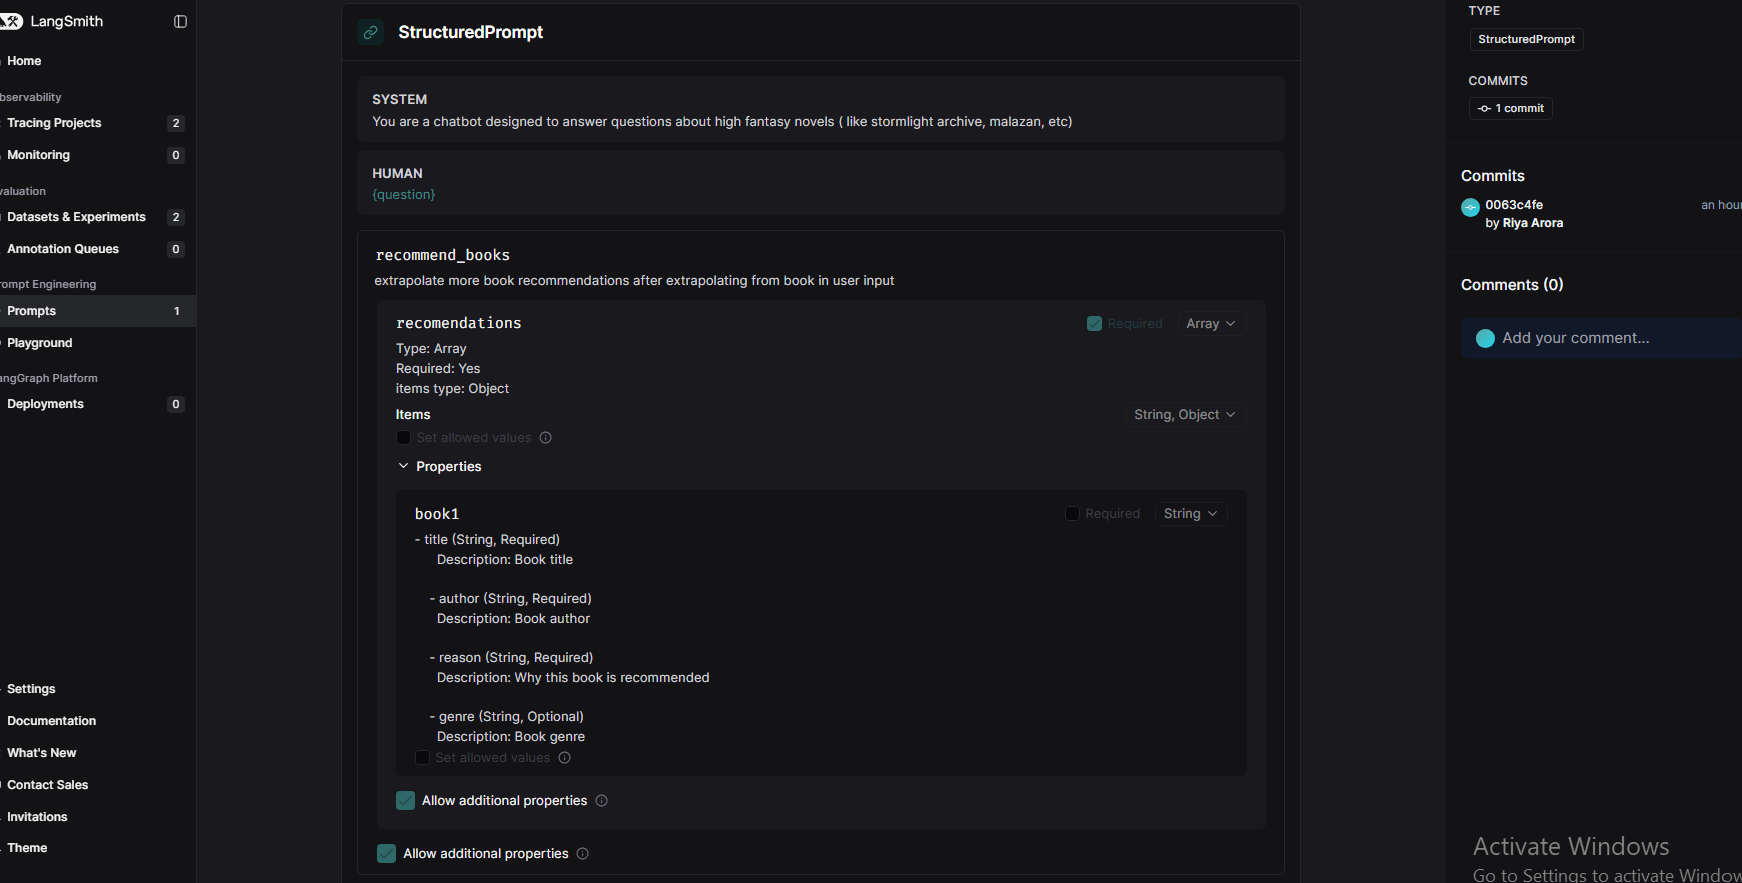
#prompt hub including the chat model configuration (i have used gemini instead of OpenAI)

In [23]:
# Create a LANGSMITH_API_KEY in Settings > API Keys
from langsmith import Client
client = Client()
prompt = client.pull_prompt("reccomendation", include_model=True)

Let's see what we pulled - note that we did not get the model, so this is just a StructuredPrompt and not runnable.

In [24]:
prompt

StructuredPrompt(input_variables=['question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': '-', 'lc_hub_repo': 'reccomendation', 'lc_hub_commit_hash': 'b32ffa4347161f1dcd65cb843fe630f42e58268abdf6f544f5e6d53159e8fd9d'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are a chatbot designed to answer questions about high fantasy novels (like stormlight archive, malazan)'), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, template='{question}'), additional_kwargs={})], schema_={'title': 'recommend_books', 'description': "give book recommendations based on the user's inputted book", 'type': 'object', 'properties': {'reccomendations ': {'type': 'array', 'description': 'List of book recommendations', 'items': {'type': 'object', 'properties': {'book 1': {'type': 'string', 'description': '- title (Str

In [ ]:
#the output schema that i have created i copied the object from the langsmith dashboard to use in my code. here we an see what it's pulled.

Cool! Now let's hydrate our prompt by calling .invoke() with our inputs

In [25]:
hydrated_prompt = prompt.invoke({"question": "I like 'a series of unfortunate events' give me other book recommendations i will like"})
hydrated_prompt

Key 'additionalProperties' is not supported in schema, ignoring
Key 'strict' is not supported in schema, ignoring
Key 'parameters' is not supported in schema, ignoring


{'reccomendations ': [{'book 1': "If you liked the plot and writing style of 'A Series of Unfortunate Events', you may enjoy this book"},
  {'book 1': "If you liked the plot and writing style of 'A Series of Unfortunate Events', you may enjoy this book"}]}

And now let's pass those messages to OpenAI and see what we get back!

In [36]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import ChatPromptTemplate

# Your output schema
output_schema = {
    "name": "recommend_books",
    "description": "give book recommendations based on the user's inputted book",
    "parameters": {
        "type": "object",
        "properties": {
            "recommendations": {
                "type": "array",
                "description": "List of book recommendations",
                "items": {
                    "type": "object",
                    "properties": {
                        "title": {
                            "type": "string",
                            "description": "The title of the recommended book"
                        },
                        "author": {
                            "type": "string",
                            "description": "The author of the recommended book"
                        },
                        "reason": {
                            "type": "string",
                            "description": "Why this book is recommended based on the user's input"
                        },
                        "genre": {
                            "type": "string",
                            "description": "The genre of the book"
                        },
                        "similarity_score": {
                            "type": "number",
                            "description": "How similar this book is to the user's input (0-10)"
                        }
                    }
                }
            }
        },
        "required": ["recommendations"]
    }
}

# Create your prompt template (use the same one from LangSmith)
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful book recommendation assistant."),
    ("user", "{question}")
])

# Initialize Gemini
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash", 
    temperature=0.7,
)

# Apply structured output
structured_llm = llm.with_structured_output(output_schema)

# Create chain
chain = prompt | structured_llm

# Get recommendations
recommendations = chain.invoke({
    "question": "I like 'a series of unfortunate events' give me other book recommendations i will like"
})

print(recommendations)

{'recommendations': [{'title': 'The Bad Beginning', 'genre': "Children's Literature", 'similarity_score': 9.0, 'author': 'Lemony Snicket', 'reason': 'Similar writing style and dark humor'}, {'title': 'Coraline', 'genre': 'Horror', 'similarity_score': 7.0, 'author': 'Neil Gaiman', 'reason': 'The book has a similar sense of dread and mystery.'}, {'title': 'The Name of this Book Is Secret', 'similarity_score': 8.0, 'genre': "Children's Literature", 'author': 'Pseudonymous Bosch', 'reason': 'This book has a similar tone, and has a mysterious plot.'}]}


In [37]:
response

AIMessage(content='Okay, I understand you\'re looking for books similar to "A Series of Unfortunate Events."  That series is known for its dark humor, clever wordplay, gothic atmosphere, and resourceful but unlucky protagonists facing absurd and often cruel situations. Given that, here are some recommendations, categorized by which aspect of the series they emphasize:\n\n**If You Enjoyed the Dark Humor and Absurdity:**\n\n*   **"Good Omens" by Terry Pratchett and Neil Gaiman:** This is a hilarious and witty apocalypse story. It features an angel and a demon who have become fond of Earth and team up to prevent the end of the world. It\'s full of clever dialogue, absurd situations, and a similar sense of humor to Lemony Snicket.\n\n*   **"Dirk Gently\'s Holistic Detective Agency" by Douglas Adams:**  If you like your mysteries with a heavy dose of British humor and completely illogical solutions, this is for you.  It\'s absurd, mind-bending, and utterly hilarious.\n\n**If You Enjoyed the

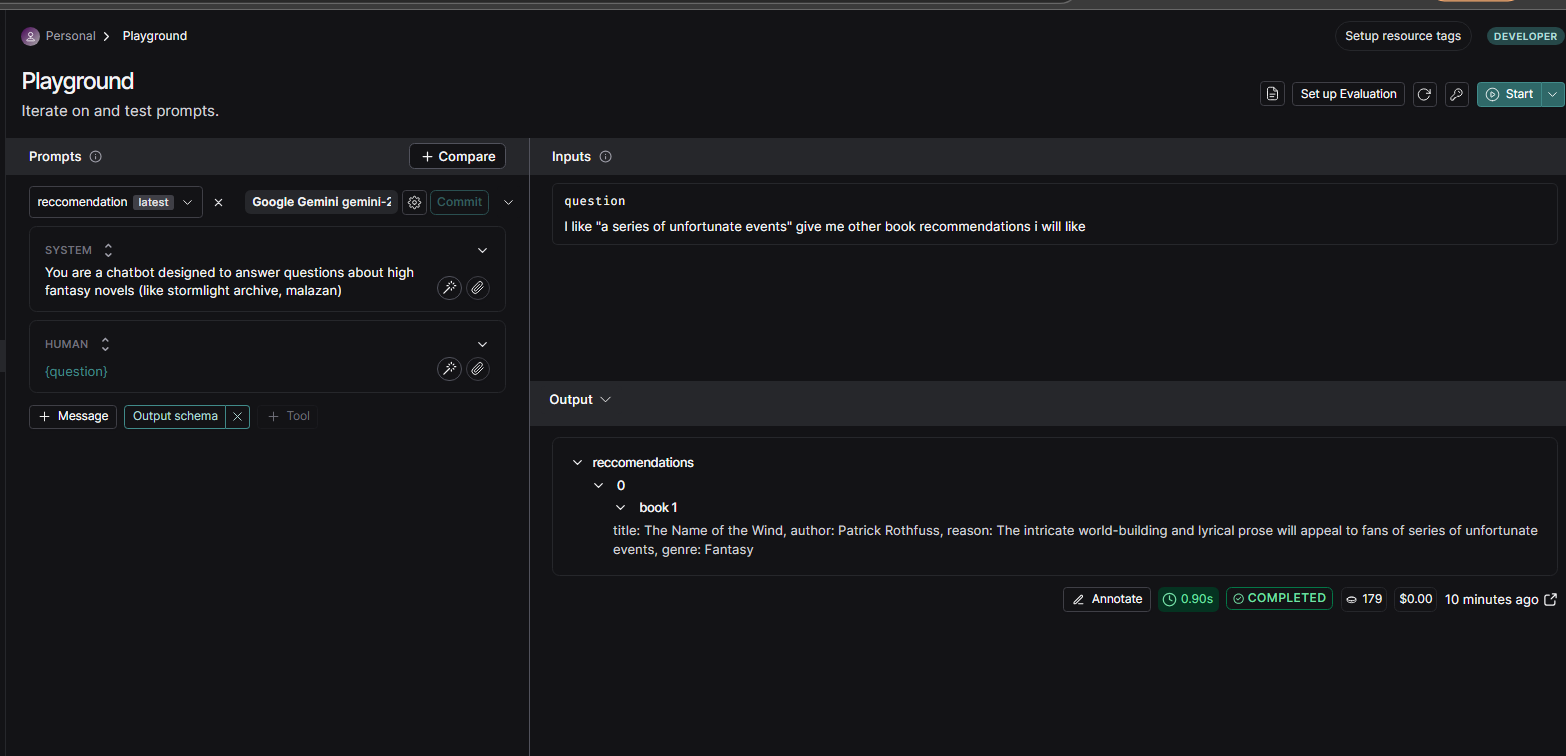
here in the UI also we can see the output according to the schema

##### [Extra: LangChain Only] Pulling down the Model Configuration

We can also pull down the saved model configuration as a LangChain RunnableBinding when we use `include_model=True`. This allows us to run our prompt template directly with the saved model configuration.

In [ ]:
prompt

Test out your prompt!

In [ ]:
prompt.invoke({"question": "Are you a captain yet?", "language": "Spanish"})

### Pull down a specific commit

Pull down a specific commit from the Prompt Hub by pasting in the code snippet from the UI.

Run this commit!

In [ ]:
from openai import OpenAI
from langsmith.client import convert_prompt_to_openai_format

openai_client = OpenAI()

hydrated_prompt = prompt.invoke({"question": "What is the world like?", "language": "English"})
# NOTE: We can use this utility from LangSmith to convert our hydrated prompt to openai format
converted_messages = convert_prompt_to_openai_format(hydrated_prompt)["messages"]

openai_client.chat.completions.create(
        model="gpt-4o-mini",
        messages=converted_messages,
    )

### Uploading Prompts

You can also easily update your prompts in the hub programmatically.



In [38]:
from langchain.prompts.chat import ChatPromptTemplate
from langsmith import Client

client=Client()

hindi_prompt = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation.

Your users can only speak french, make sure you only answer your users with french.

Conversation: {conversation}
Context: {context} 
Question: {question}
Answer:"""

hindi_prompt_template = ChatPromptTemplate.from_template(hindi_prompt)
client.push_prompt("hindi-rag-prompt", object=hindi_prompt_template)

'https://smith.langchain.com/prompts/hindi-rag-prompt/6fed6fb1?organizationId=77d67426-6a1f-41ce-a548-a2541cd626c7'

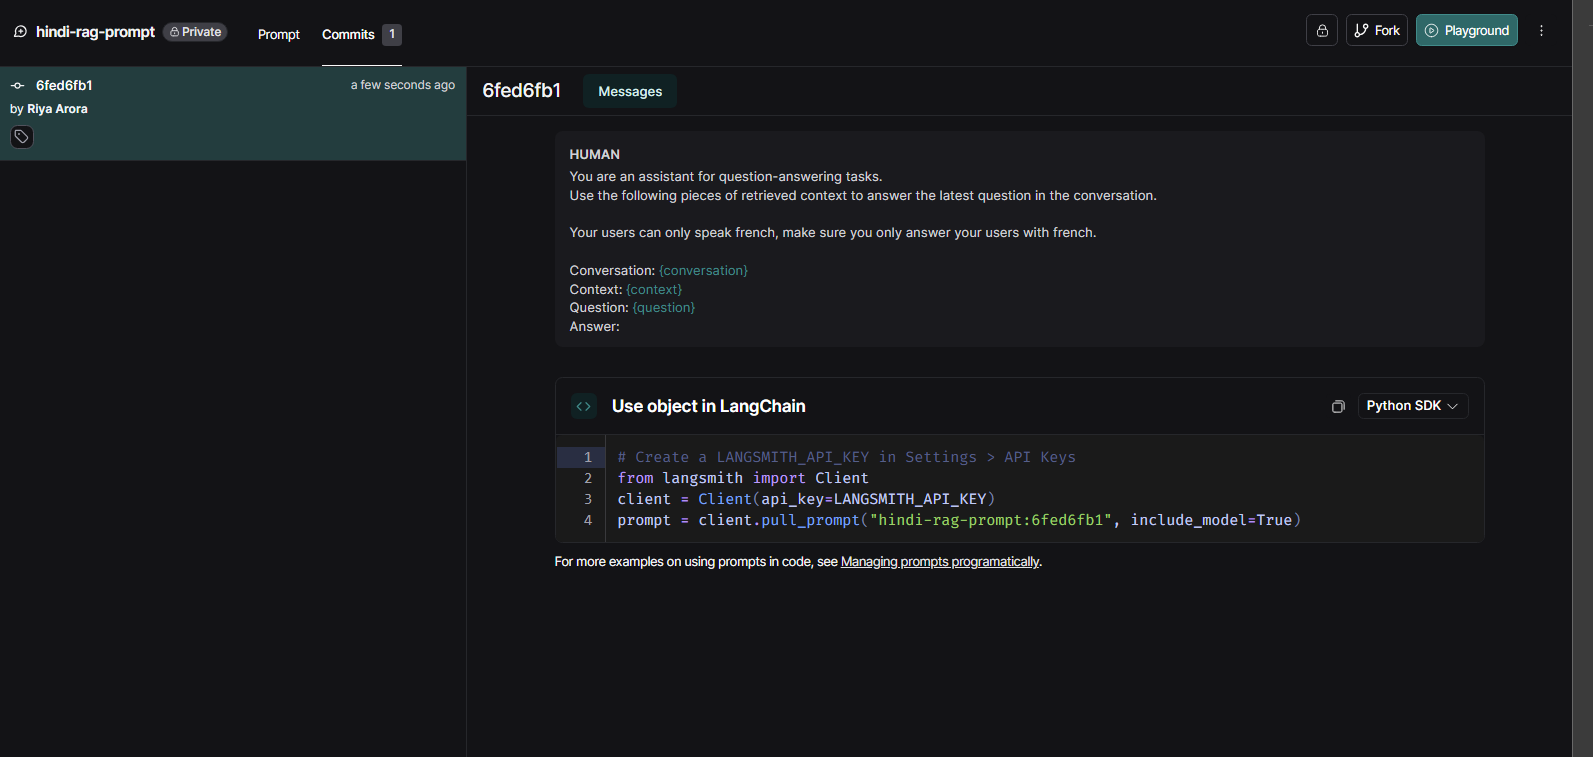

You can also push a prompt as a RunnableSequence of a prompt and a model. This is useful for storing the model configuration you want to use with this prompt. The provider must be supported by the LangSmith playground.